# Context Maintenance and Retrieval (CMR) Model

The model (Polyn, Norman & Kahana, 2009) combines:

- **Episodic associations**: Learned connections between items and the temporal context in which they were presented
- **Semantic associations**: Pre-existing associations between items based on their meaning
- **Context drift**: gradual change in mental context over time during encoding and retrieval

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import zscore
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

## Retrieval weights

These parameters control the relative strength of semantic versus episodic retrieval routes:

1. **sem**: Weight of semantic associations (meaning-based connections)
2. **episodic**: Weight of episodic associations (temporal context-based connections)

- Weights are normalized so they sum to 1, determining the relative contribution of each route during memory retrieval. 
- Equal weights (0.5/0.5) mean both routes contribute equally to recall.

In [52]:
# strength of drift
# scale_drift = 0.4  # scaling parameter (not used if inputting manual drift)

# strength of semantic + episodic route
sem = 0.5
episodic = 0.5

# normalize
sem_weight = sem / (episodic + sem)
episodic_weight = episodic / (episodic + sem)

## Reward Sequence

Defines the presentation order and values of items in the simulated memory list:

- **pres_indices**: Random permutation determining the order items are presented
- **sequence**: Reward values associated with each position (used to calculate prediction errors)

The "primacy" sequence used here shows gradually decreasing values (54 → 45), which can affect context drift when prediction error-based drift is enabled. This simulates scenarios where reward or value changes over the course of a sequence.

In [53]:
# random sample (1-indexed to match R behavior, then convert to 0-indexed)
pres_indices = np.random.permutation(10) + 1

# high RPE within sequence
# sequence = np.array([0, 54, 57, 56, 53, 55, 7, 5, 4, 6, 3])  # initial expectation is 0

# primacy (first outcome is "reward expectation" at 50)
sequence = np.array([50, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45])

## Dynamic Drift

**Context drift** refers to how quickly the mental context changes during encoding. This section (currently commented out) implements dynamic drift based on prediction errors:

**Logic**:
1. Calculate absolute prediction errors (difference between consecutive rewards)
2. Z-score normalize the prediction errors
3. Scale by `scale_drift` parameter
4. Cap maximum drift at 1.0

**Interpretation**: Larger prediction errors cause greater context drift, meaning unexpected events create stronger temporal boundaries in memory. This can enhance memory for items around surprising events.

This approach is currently disabled in favor of manual drift specification below.

In [54]:
# dynamic beta
# absPE = np.zeros((len(pres_indices), 1))

# take absolute difference of previous reward with current reward
# (first "prediction error" is reward - initial expectation)
# for seq in range(len(sequence) - 1):
#     absPE[seq] = abs(sequence[seq] - sequence[seq + 1])

# take absolute value of z-scored absPE and multiply by scaling parameter
# B_encD = np.abs(zscore(absPE)) * scale_drift

# B_encD = np.where(B_encD > 1, 1, B_encD)  # if it's over 1, make it 1

## Manual Drift

Manually specified context integration rates (β values) for each item during encoding:

- **B_encD[0] = 1.0**: First item causes maximum context drift (complete context update)
- **B_encD[1:] = 0.65**: Subsequent items cause moderate drift

**Interpretation**: High drift for the first item creates a strong primacy effect - the first item becomes strongly associated with the initial context state. Lower drift for subsequent items means they blend more with the evolving context, creating temporal associations between nearby items.

In [55]:
# manual drift (comment out if using modulated or stable drift)
B_encD = np.array([1, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65])

## Semantic Matrix

Defines pre-existing semantic associations between items:

- **Identity matrix structure**: Each item has activation of 1.0 to itself, 0 to all others
- This represents **orthogonal** items with no semantic similarity

**Interpretation**: In this simple version, items have no inherent semantic relationships. The semantic route will primarily help retrieve items based on their direct activation rather than meaning-based associations. For more realistic simulations, this could be replaced with a structured similarity matrix based on word associations, categories, etc.

In [56]:
# create "semantic" matrix
# each item has an activation of 1 (and to no other units)
sem_mat = np.eye(len(pres_indices))

## Parameters calibrated to human free recall data

### Network Architecture
- **gamma_fc (0.581)**: Strength of pre-existing feature-context associations
- **eye_fc, eye_cf**: Initialize connection matrices

### Encoding Parameters
- **B_enc (0.745)**: Standard context integration rate during study
- **lrate_fc_enc**: Learning rate for feature→context connections
- **lrate_cf_enc**: Learning rate for context→feature connections

### Retrieval Parameters
- **B_rec (0.36)**: Context integration during recall (slower than encoding)
- **lrate_fc_rec, lrate_cf_rec (0)**: No new learning during recall

### Decision Competition
- **thresh (1)**: Activation threshold for successful recall
- **L (0.375)**: Lateral inhibition between competing items
- **K (0.091)**: Decay rate of accumulator activation
- **eta (0.3699)**: Noise in the decision process
- **tau (413 ms)**: Time constant for accumulation

These parameters create a competitive retrieval process where items race to threshold, with noise and inhibition producing realistic recall dynamics.

In [57]:
gamma_fc = 0.581  # relative strength of pre-existing associations on connections feature-context
eye_fc = 1 - gamma_fc  # if items are rep as orthonormal vectors, identity matrix ("eye")
eye_cf = 0

# during encoding
B_enc = 0.745  # vector of context integration rate at encoding (dynamic alternative above)
lrate_fc_enc = gamma_fc  # feature-to-context during encoding
lrate_cf_enc = 1  # context-to-feature during encoding

# during recall
B_rec = 0.36  # vector of context integration at recall
lrate_fc_rec = 0  # feature-to-context during recall
lrate_cf_rec = 0  # context-to-feature during recall
thresh = 1  # threshold for an accumulating element to win
rec_time = 90000  # max recall process (90 seconds)
dt = 100  # time constant on decision process
L = 0.375  # lateral inhibition between units
K = 0.091  # decay rate for the accumulating element
eta = 0.3699  # standard deviation of gaussian noise term in decision competition
tau = 413  # time constant in decision competition

n_sims = 1000  
recall_sims = np.zeros((len(pres_indices), n_sims))
times_sims = np.zeros((len(pres_indices), n_sims))

# Model Run

Main simulation loop implementing the CMR model's encoding and retrieval phases.

## Overall Structure
For each simulation:
1. **Initialize network**: Create feature and context layers, connection weights
2. **Encoding phase**: Present items sequentially, update context and associations
3. **Retrieval phase**: Use context cues to retrieve items via competitive accumulation

## Encoding Phase Logic
For each presented item:
1. Activate the item's feature representation
2. Calculate context input from feature layer (via learned associations)
3. Update context using drift equation: `c_new = ρ·c_old + β·c_in`
   - **ρ (rho)**: Ensures context vector stays normalized
   - **β (beta)**: Controls integration rate (how much context changes)
4. Learn associations between active features and current context

So **two** “jobs” happening with each new item:
1. Update the state (context vector c)
2. Update the memory traces (associative matrices $M^{FC}$, $M^{CF}$)

## Retrieval Phase Logic
Iterative process until time runs out:
1. Use current context to activate features (via episodic + semantic routes)
2. Run accumulator race:
   1) Each item accumulates activation based on its cue strength
   2) Lateral inhibition suppresses competitors
      - Every item inhibits every other item by strength L, but does not inhibit itself.
   3) Noise creates variability
      - Each item’s evidence accumulator jitters randomly at each timestep.
   4) Decay prevents runaway activation
      - All accumulators leak at the same rate K
3. When an item crosses threshold:
   - Record the recall
   - Mark item as retrieved & prevent repetitions:
      - Step 1: find items that are already retrieved and have accumulator level above threshold
      - Step 2: push them under threshold by setting them to 0.95 * threshold
	   - Already recalled items remain almost winning but will not trigger another recall
   - Use retrieved item to update context
   - Continue with new context state

> Each recall changes context, which determines what gets recalled next (temporal contiguity effect)

In [58]:
for sims in range(n_sims):
    
    # initialize features and context layers
    net_f = np.zeros((len(pres_indices), 1)) # when item i is presented, set net_f[i]=1
    net_c = np.zeros((len(pres_indices), 1)) 
    
    # learning rate matrices
    net_lrate_fc = np.zeros((len(pres_indices), len(pres_indices))) # N×N zeros
    net_lrate_cf = np.zeros((len(pres_indices), len(pres_indices))) # N×N zeros
    # These are meant to be overwritten by the active learning-rate matrix 
    # e.g., during encoding set to net_lrate_fc_enc, during recall set to net_lrate_fc_rec
    # So these are placeholder variables, not true parameters.
   
    net_lrate_fc_enc = np.full((len(pres_indices), len(pres_indices)), lrate_fc_enc) # N×N filled with lrate_fc_enc
    net_lrate_cf_enc = np.full((len(pres_indices), len(pres_indices)), lrate_cf_enc) # N×N filled with lrate_cf_enc
    net_lrate_fc_rec = np.full((len(pres_indices), len(pres_indices)), lrate_fc_rec) # N×N filled with lrate_fc_rec
    net_lrate_cf_rec = np.full((len(pres_indices), len(pres_indices)), lrate_cf_rec) # N×N filled with lrate_cf_rec
    # Because learning rates are constant everywhere, these matrices are functionally equivalent to scalars
    
    # associative weight matrices
    net_w_fc = np.eye(len(net_c)) * eye_fc  # eye() creates identity matrices
    net_w_cf = np.eye(len(net_f)) * eye_cf  
    net_weights = np.zeros((len(pres_indices), len(pres_indices))) # placeholder variable
    
    # ––––––––––––––––––––––– ENCODING –––––––––––––––––––––––

    net_idx = np.arange(len(pres_indices))
    
    for item in range(len(pres_indices)):
        
        # present item
        feature_idx = pres_indices[item] - 1  # Convert to 0-indexed
        
        # activates the indexed feature (each item activates one element)
        net_f = np.zeros((len(pres_indices), 1))
        net_f[feature_idx] = 1
        
        # –––––––––––––––––– Update state ––––––––––––––––––
        # update context representations
        net_c_in = net_w_fc @ net_f
        
        # normalize vector
        vec = net_c_in
        denom_vec = np.sqrt(vec.T @ vec)[0, 0]
        norm_vec = vec / denom_vec
        net_c_in = norm_vec
        
        # advance context
        c_in = net_c_in
        c = net_c
        
        # set dynamic or stable drift
        B = B_encD[item]  # beta at encoding for dynamic
        # B = B_enc  # beta at encoding if stable
        
        dot_product = (c.T @ c_in)[0, 0]
        rho = np.sqrt(1 + (B**2) * ((dot_product**2) - 1)) - B * dot_product
        updated_c = rho * c + B * c_in
        net_c = updated_c
        
        # ––––––––– Update memory traces –––––––––––
        # determine current learning rate
        lrate_fc = net_lrate_fc_enc
        lrate_cf = net_lrate_cf_enc
        
        # update weights
        # w_fc
        delta = (net_c @ net_f.T) * lrate_fc
        net_w_fc = net_w_fc + delta
        # w_cf
        delta = (net_f @ net_c.T) * lrate_cf
        net_w_cf = net_w_cf + delta
    
    # ––––––––––––––––––––––––– RECALL ––––––––––––––––––––––––––––
    
    # set up
    recalls = np.zeros((len(pres_indices), 1))
    times = np.zeros((len(pres_indices), 1))
    
    rec_time_local = 90000
    time_passed = 0
    recall_count = 0
    
    retrieved = np.zeros((len(pres_indices), 1), dtype=bool)
    thresholds = np.ones((len(pres_indices), 1))
    
    # semantic + episodic routes
    net_weights = episodic_weight * net_w_cf + sem_weight * sem_mat
    
    # –––––––––––––––––––– GO!!! ––––––––––––––––––––
    
    while time_passed < rec_time_local:
        
        # input to the feature layer, from last context cue
        f_in = net_weights @ net_c
        
        # set max number of cycles
        max_cycles = int((rec_time_local - time_passed) / dt)
        
        # Noise error standard deviation
        dt_tau = dt / tau
        sq_dt_tau = np.sqrt(dt_tau) # noise scales with √time in diffusion processes
        
        # Pre-generate all noise for the whole recall period (matrix of Gaussian noise)
        noise = np.random.normal(0, eta * sq_dt_tau, (len(pres_indices), max_cycles))
        
        # Build lateral inhibition matrix
        eyeI = ~np.eye(len(pres_indices), dtype=bool) # True off-diagonal, False on diagonal
        lmat = eyeI.astype(float) * L
        
        # Utility variables for looping
        ncycles = noise.shape[1]
        inds = np.arange(len(pres_indices))
        
        # Track whether any item has hit threshold yet
        crossed = 0
        
        # Initialize accumulator activations for all items
        x = np.zeros((len(pres_indices), 1))
        
        # Expand the leak parameter to match dimensionality
        K_array = np.ones((len(pres_indices), 1)) * K
        
        # Start cycle counter
        i = 0
        
        # –––––––––––––– ACCUMULATORS CYCLING –––––––––––––––
        while i < ncycles and crossed == 0:
            
            # lateral inhibition felt by each unit
            lx = lmat @ x
            
            # leaking from each unit
            kx = K_array * x
            
            # change in each accumulator
            x = x + ((f_in - kx - lx) * dt_tau + noise[:, i:i+1])
            x[x < 0] = 0
            
            # reset retrieved values, allow them to compete but prevent from accumulating
            reset_these = retrieved & (x >= thresholds)
            x[reset_these] = 0.95 * thresholds[reset_these]
            
            # retrieved items cannot be repeated
            retrievable = ~retrieved
            
            # determine whether any items have crossed thresholds
            crossed = 0
            if np.any(x[retrievable] >= thresholds[retrievable]):
                crossed = 1
                temp_win = x[retrievable] >= thresholds[retrievable]
                temp_ind = inds[retrievable.flatten()]
                winners = temp_ind[temp_win.flatten()]
                
                # if there is a tie, random tiebreak
                if len(winners) > 1:
                    winners = np.array([np.random.choice(winners)])
                
                winner_position = np.where(pres_indices - 1 == winners[0])[0][0]
            
            i = i + 1
        
        # calculate the amount of elapsed time
        time = i * dt
        time_passed = time_passed + time
        
        # reactivate item if there has been a retrieval
        if crossed == 1:
            
            # activate the retrieved feature
            net_f = np.zeros((len(pres_indices), 1))
            net_f[winners[0]] = 1
            
            # update context representations
            net_c_in = net_w_fc @ net_f
            
            # normalize vector
            vec = net_c_in
            denom_vec = np.sqrt(vec.T @ vec)[0, 0]
            norm_vec = vec / denom_vec
            net_c_in = norm_vec
            
            # advance context
            c_in = net_c_in
            c = net_c
            B = B_rec  # beta at retrieval
            
            dot_product = (c.T @ c_in)[0, 0]
            rho = np.sqrt(1 + (B**2) * ((dot_product**2) - 1)) - B * dot_product
            updated_c = rho * c + B * c_in
            net_c = updated_c
            
            # determine current learning rate
            lrate_fc = net_lrate_fc_rec
            lrate_cf = net_lrate_cf_rec
            
            # w_fc
            delta = (net_c @ net_f.T) * lrate_fc
            net_w_fc = net_w_fc + delta
            
            # w_cf
            delta = (net_f @ net_c.T) * lrate_cf
            net_w_cf = net_w_cf + delta
            
            # record data
            recall_count = recall_count + 1
            recalls[recall_count - 1, 0] = winner_position + 1  # Convert back to 1-indexed
            times[recall_count - 1, 0] = time_passed
            
            # update retrieved vector
            retrieved[winners[0]] = True
    
    recall_sims[:, sims] = recalls.flatten()
    times_sims[:, sims] = times.flatten()

print(f"Model run complete. Simulated {n_sims} trials.")

Model run complete. Simulated 1000 trials.


> `recall_sims` is a matrix shaped like:
 $(\text{recall output index}) \times (\text{simulation number})$

# Serial Position Curve

Analyzes recall probability as a function of an item's position in the study list.

## Calculation Logic
For each serial position (1-10):
- Count how many times items from that position were recalled across all simulations
- Divide by total number of simulations to get recall probability

## Expected Pattern
- **Primacy effect**: Higher recall for early items (positions 1-3)
  - In full CMR2, primacy is implemented with a primacy gradient $(ϕ_s, ϕ_d)$. This notebook does not include that.
- **Recency effect**: Higher recall for recent items (positions 8-10)
  - Emergent from the fact recall starts with the last context state
  - Caused by end-of-list context still being active during recall

In [59]:
# create a column [1..N] just for labeling
position = pd.DataFrame({'position': np.arange(1, len(pres_indices) + 1)})

# create an array of length N to store counts
numSums = np.zeros(len(pres_indices))

for numSum in range(len(numSums)):
    numSums[numSum] = np.sum(recall_sims == (numSum + 1))
    # recall_sims: boolean matrix storing serial positions (1..N) for each recall event
    # True wherever that serial position was recalled
    # count how many True across the whole matrix

recall = numSums / n_sims

prop_recall = pd.DataFrame({
    'position': position['position'],
    'recall': recall
})

print(prop_recall)

   position  recall
0         1   0.098
1         2   0.099
2         3   0.157
3         4   0.279
4         5   0.450
5         6   0.684
6         7   0.879
7         8   0.988
8         9   0.995
9        10   1.000


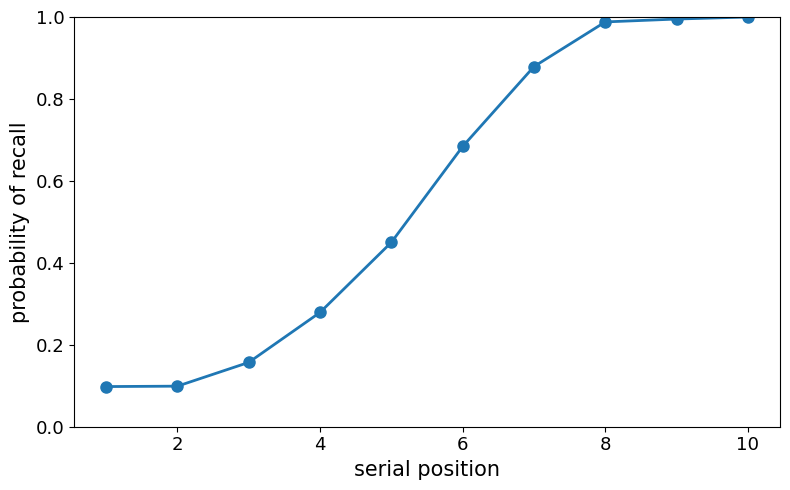

In [60]:
plt.figure(figsize=(8, 5))
plt.plot(prop_recall['position'], prop_recall['recall'], 'o-', linewidth=2, markersize=8)
plt.xlabel('serial position', fontsize=15)
plt.ylabel('probability of recall', fontsize=15)
plt.ylim(0, 1)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(False)
plt.tight_layout()
plt.show()

- Roughly constant encoding drift (mostly $B \approx 0.65$) makes similarity between each item’s context and the end-of-list context decrease monotonically with distance (earlier serial positions are less similar). 
    - This creates a monotonic gradient in initial retrieval cue strength, though not necessarily a monotonic curve in recall probability. 
- The S-shaped recall probability emerges from the recall stage: a noisy, competitive accumulator with thresholding and finite time

## First Recall Probability

Analyzes which items are most likely to be recalled first when retrieval begins.

### Calculation Logic
- Extract the first recalled item from each simulation
- Count frequency of each position being recalled first
- Convert to proportions
    - proportion of all simulations (including nothing-recalled cases)

### Theoretical Predictions
First recall is strongly influenced by:
1. **Recency**: Recent items have highest context match with end-of-list state
2. **Primacy**: With high initial drift, first item may have unique retrieval advantage
3. **Semantic strength**: Items with strong semantic cues may be recalled first

In [61]:
# each number is a serial position of the first recalled item in that simulation
first_recall = recall_sims[0, :] 
# filter out zeros (remove nothing recalled cases)
first_recall = first_recall[first_recall > 0] 

# create frequency table for:
# A: sorted list of distinct serial positions observed
# B: how many times each appeared
unique, counts = np.unique(first_recall, return_counts=True)
first_recall_table = pd.DataFrame({
    'position': unique.astype(int),
    'freq': counts,
    'prop': counts / n_sims
})

print(first_recall_table)

   position  freq   prop
0         1     2  0.002
1         2     3  0.003
2         3     5  0.005
3         4     1  0.001
4         5     4  0.004
5         6    14  0.014
6         7    22  0.022
7         8    78  0.078
8         9   222  0.222
9        10   649  0.649


In free recall, the last few items dominate first recalls due to context matching.

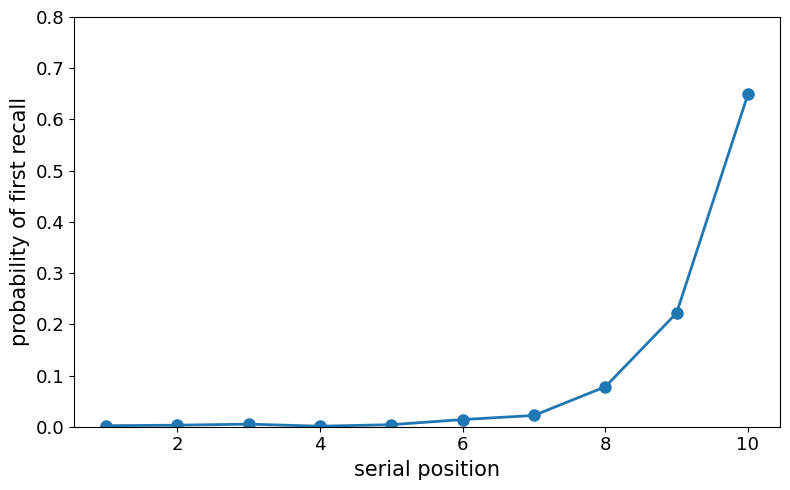

In [62]:
plt.figure(figsize=(8, 5))
plt.plot(first_recall_table['position'], first_recall_table['prop'], 'o-', linewidth=2, markersize=8)
plt.xlabel('serial position', fontsize=15)
plt.ylabel('probability of first recall', fontsize=15)
plt.ylim(0, 0.8)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(False)
plt.tight_layout()
plt.show()

## Conditional Response Probabilities (CRP)

Analyzes **temporal contiguity effect**: tendency to recall items that were studied near each other in time.

### Calculation Logic

#### 1. Actual Transitions
For each recall sequence, compute the serial-positional "lag" between consecutive recalls:
- Lag = (position of item N+1) - (position of item N)
- E.g., positions 5→7 recalled, lag = +2; positions 8→6 recalled, lag = -2

#### 2. Possible Transitions
At each recall, determine which items could still be recalled:
- Exclude already-recalled items
- Calculate all possible lags from current position

#### 3. Conditional Probabilities
For each lag value:
- CRP(lag) = P(transition to lag | lag is available)
- CRP(lag) = (# actual transitions of lag) / (# times lag was available)

#### Rationale
- High CRP values: Strong tendency for that lag
- Low CRP values: Weak tendency or random transitions

### 1 & 2: Create matrix of actual & possible transitions

In [63]:
poss_outcomes = np.arange(-9, 10)
poss_outcomes = np.delete(poss_outcomes, 9)  # remove element at index 9 (value 0)

# create matrix of actual transitions
trans_sims = np.zeros((len(pres_indices), n_sims))

for subj in range(n_sims):
    currentSub = recall_sims[:, subj]
    
    for trial in range(9):
        if currentSub[trial + 1] > 0:
            trans_sims[trial, subj] = currentSub[trial + 1] - currentSub[trial]
        else:
            trans_sims[trial, subj] = 0

# create matrix of all possible transitions
possTransFrame = []

for subj in range(n_sims):
    currentSub = recall_sims[:, subj]
    possTrans_sims = np.zeros((10, 9))
    
    for trial in range(9):
        if currentSub[trial + 1] > 0:
            currentTrial = currentSub[trial]
            itemTally = currentSub[0:trial + 1]
            possPositions = pres_indices[~np.isin(pres_indices, itemTally)]
            possTransitions = possPositions - currentTrial
            
            for poss in range(len(possTransitions)):
                possTrans_sims[trial, poss] = possTransitions[poss]
    
    possTransFrame.append(possTrans_sims)

possTransFrame = np.vstack(possTransFrame)

### 3: Conditional response probability for each lag:

1. **Filter transitions**: focus on lags within ±5 positions
2. **Calculate probabilities**: divide actual transitions by possible transitions

In [64]:
# create CRP
actual_transitions = trans_sims[trans_sims != 0]
possible_transitions = possTransFrame[possTransFrame != 0]

# Count frequencies
tab_a_t_unique, tab_a_t_counts = np.unique(actual_transitions, return_counts=True)
tab_p_t_unique, tab_p_t_counts = np.unique(possible_transitions, return_counts=True)

tab_a_t = pd.DataFrame({
    'actual_transitions': tab_a_t_unique,
    'Freq': tab_a_t_counts
})

tab_p_t = pd.DataFrame({
    'possible_transitions': tab_p_t_unique,
    'Freq': tab_p_t_counts
})

# Filter
tab_a_t = tab_a_t[(tab_a_t['actual_transitions'] < 6) & (tab_a_t['actual_transitions'] > -6)]
tab_p_t = tab_p_t[(tab_p_t['possible_transitions'] < 6) & (tab_p_t['possible_transitions'] > -6)]

# Calculate CRP
crp = tab_a_t['Freq'].values / tab_p_t['Freq'].values

crps = pd.DataFrame({
    'transitions': tab_a_t['actual_transitions'].values,
    'crp': crp
})

### Visualization

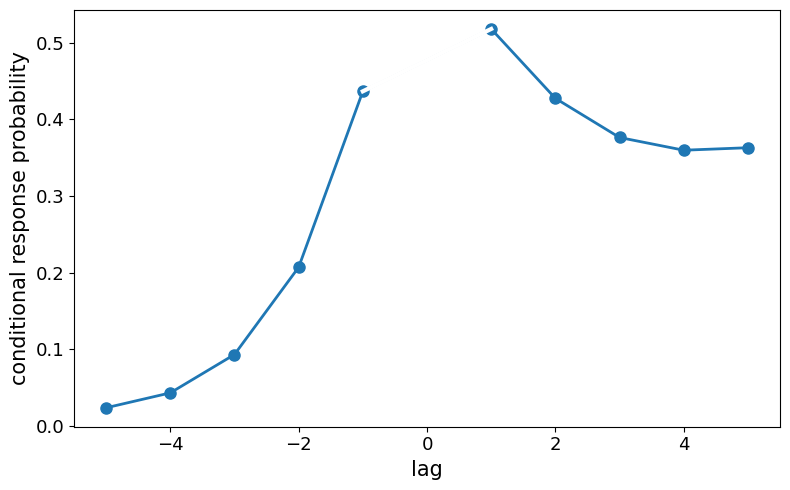

In [65]:
# plot CRP
plt.figure(figsize=(8, 5))
plt.plot(crps['transitions'], crps['crp'], 'o-', linewidth=2, markersize=8)

# Add white segments to mask the gap at lag 0 (between -1 and 1)
mask_indices = (crps['transitions'] == -1) | (crps['transitions'] == 1)
if mask_indices.sum() == 2:
    idx_neg1 = crps[crps['transitions'] == -1].index[0]
    idx_pos1 = crps[crps['transitions'] == 1].index[0]
    plt.plot([-1, 1], [crps.loc[idx_neg1, 'crp'], crps.loc[idx_pos1, 'crp']], 
             'w-', linewidth=3, zorder=10)

plt.xlabel('lag', fontsize=15)
plt.ylabel('conditional response probability', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(False)
plt.tight_layout()
plt.show()

### Interpretation
- **Peak at lag ±1**: strongest tendency to recall adjacent items
- **Asymmetry**: stronger forward (positive lag) than backward
- Probability decreases for distant items
- **Gap at lag 0**: Can't recall the same item twice

> Peaked shape demonstrates that context serves as an effective retrieval cue: items studied in similar temporal contexts are recalled together. 

## Weight Matrices

Learned associations between items and temporal context after encoding.

#### Feature-to-Context ($M^{FC}$)
- **Rows**: Context elements
- **Columns**: Item positions (serial order)
- **Values**: How strongly each item activates each context element
- **Interpretation**: Shows what context was active when each item was encoded

#### Context-to-Feature ($M^{CF}$)
- **Rows**: Item positions
- **Columns**: Context elements  
- **Values**: How strongly each context element retrieves each item
- **Interpretation**: Shows which items are cued by each context state

These matrices implement the episodic memory feedback-loop. 
- During retrieval, current context state activates items via $M^{CF}$,
- Then, retrieved items update context via $M^{FC}$.

In [66]:
# re-organize weight matrices for plotting (so as to view them by serial position)
net_w_fc_inorder = net_w_fc[:, pres_indices - 1]  # convert to 0-indexed
net_w_cf_inorder = net_w_cf[pres_indices - 1, :]  

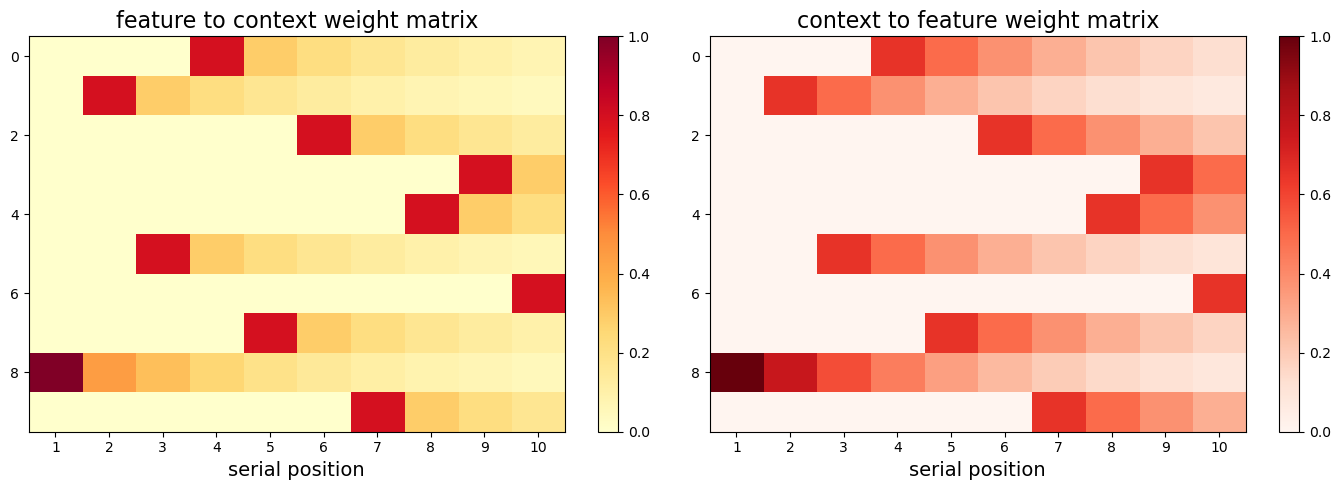

In [67]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Feature to context weight matrix
im1 = axes[0].imshow(net_w_fc_inorder, cmap='YlOrRd', aspect='auto')
axes[0].set_title('feature to context weight matrix', fontsize=16)
axes[0].set_xlabel('serial position', fontsize=14)
axes[0].set_ylabel('', fontsize=14)
axes[0].set_xticks(np.arange(len(pres_indices)))
axes[0].set_xticklabels(np.arange(1, len(pres_indices) + 1))
plt.colorbar(im1, ax=axes[0])

# Context to feature weight matrix
im2 = axes[1].imshow(net_w_cf_inorder.T, cmap='Reds', aspect='auto')
axes[1].set_title('context to feature weight matrix', fontsize=16)
axes[1].set_xlabel('serial position', fontsize=14)
axes[1].set_ylabel('', fontsize=14)
axes[1].set_xticks(np.arange(len(pres_indices)))
axes[1].set_xticklabels(np.arange(1, len(pres_indices) + 1))
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

#### Why no diagonal pattern yet:
Reordered **only one axis** (serial-position axis), but left the other axis in the model’s **raw** context-dimension order.

This mixes coordinate systems:
- x-axis: serial position space
- y-axis: raw context-dimension space

#### To reveal the diagonal pattern:
Convert the matrix into **serial-position coordinates** on *both* axes by applying the same permutation to both rows and columns:

$M^{FC}_{\text{serial}} = M^{FC}[\text{perm,perm}]$

$M^{CF}_{\text{serial}} = M^{CF}[\text{perm,perm}]$

where $\text{perm,perm}$ is the permutation that maps internal indices to serial-position order.

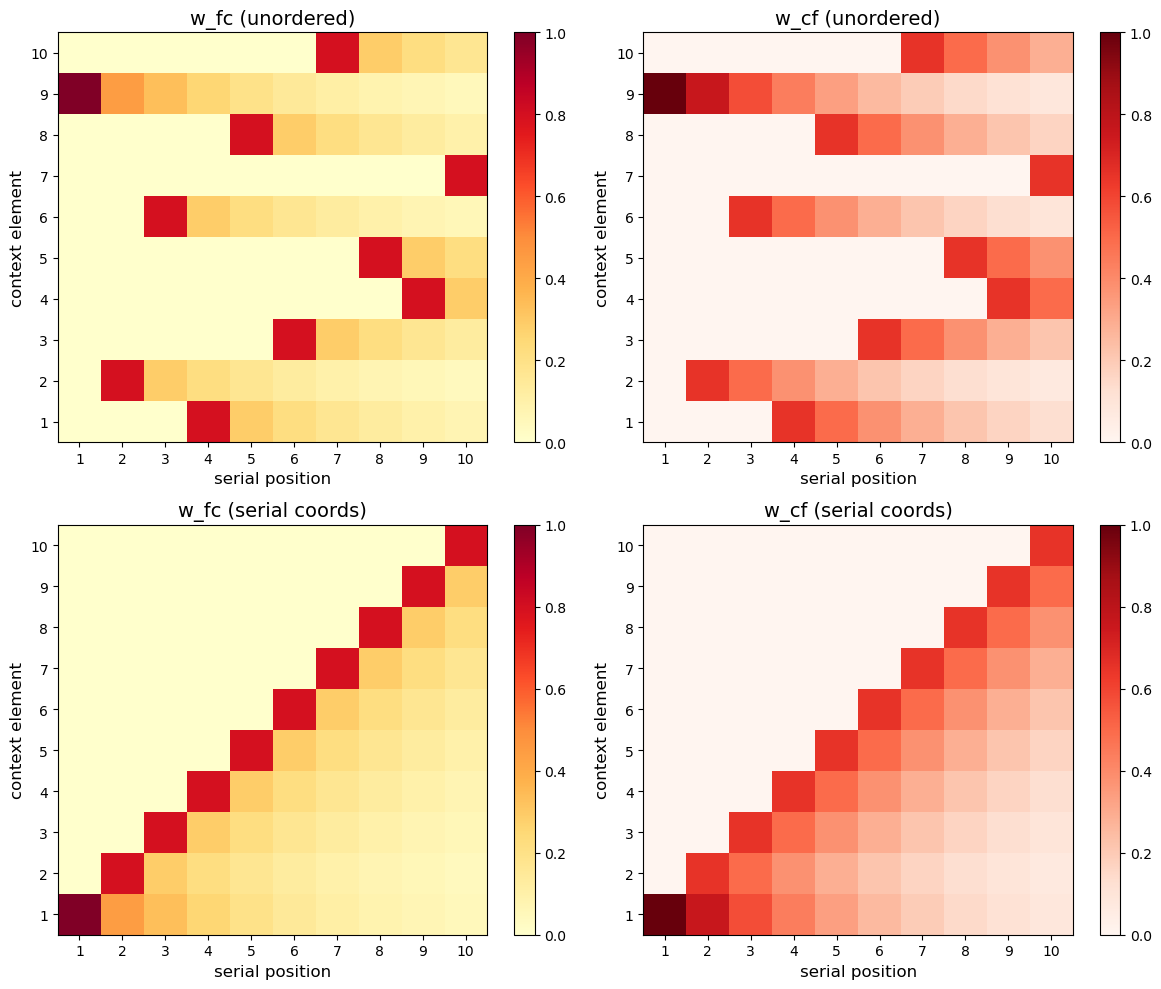

In [68]:
perm = pres_indices - 1
N = len(pres_indices)

net_w_fc_ser = net_w_fc[np.ix_(perm, perm)]
net_w_cf_ser = net_w_cf[np.ix_(perm, perm)]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# --- Unordered ---
im = axes[0,0].imshow(net_w_fc_inorder, cmap='YlOrRd', aspect='auto', origin='lower')
axes[0,0].set_title('w_fc (unordered)', fontsize=14)
plt.colorbar(im, ax=axes[0,0])

im = axes[0,1].imshow(net_w_cf_inorder.T, cmap='Reds', aspect='auto', origin='lower')
axes[0,1].set_title('w_cf (unordered)', fontsize=14)
plt.colorbar(im, ax=axes[0,1])

# --- Serial ---
im = axes[1,0].imshow(net_w_fc_ser, cmap='YlOrRd', aspect='auto', origin='lower')
axes[1,0].set_title('w_fc (serial coords)', fontsize=14)
plt.colorbar(im, ax=axes[1,0])

im = axes[1,1].imshow(net_w_cf_ser.T, cmap='Reds', aspect='auto', origin='lower')
axes[1,1].set_title('w_cf (serial coords)', fontsize=14)
plt.colorbar(im, ax=axes[1,1])

# Label all axes consistently
for ax in axes.ravel():
    ax.set_xticks(np.arange(N))
    ax.set_xticklabels(np.arange(1, N+1))
    ax.set_yticks(np.arange(N))
    ax.set_yticklabels(np.arange(1, N+1))
    ax.set_xlabel('serial position', fontsize=12)
    ax.set_ylabel('context element', fontsize=12)

plt.tight_layout()
plt.show()

- **Diagonal structure**: Items are most strongly associated with their encoding context

- **Gradient/smearing**: Due to context drift, nearby items share similar contexts
    - More smearing = more context overlap = stronger temporal associations
    - Less smearing = more distinct contexts = weaker temporal associations

- **First item distinctiveness**: High initial drift (B=1.0) create unique first-item pattern

## Correlation Matrices

Analyzes the similarity structure of learned representations by computing correlations between columns (items) of the weight matrices. 
> Items with **high context correlation** are likely to be recalled together.

#### Feature-to-Context Correlations
- Correlates context patterns activated by different items
- **High correlation**: Two items activated similar contexts (encoded nearby in time)
- **Low correlation**: Two items activated distinct contexts (encoded far apart)

#### Context-to-Feature Correlations  
- Correlates the retrieval strength patterns across context states
- **High correlation**: Two items are similarly cued by the same contexts
- **Low correlation**: Two items are cued by different contexts

### Correlation plots

1. For **feature-to-context** association matrix `net_w_fc_inorder`:
  $$M^{FC}\quad (\text{context rows} \times \text{item columns})$$

  - Transposing `net_w_fc_inorder.T` correlates **columns** of $M^{FC}$ with each other.  
  - Each column $j$ represents the **context footprint** of item $j$: $$M^{FC}_{:,j} = \text{the context pattern item } j \text{ evokes}$$

  - Therefore, $\text{corr\_fc}[j,k] = \text{similarity}\big(M^{FC}_{:,j},\; M^{FC}_{:,k}\big)$

    > `corr_fc` is an **item–item similarity matrix**, induced by $M^{FC}$.


2. For **context-to-feature** association matrix `net_w_cf_inorder`:
  $$M^{CF}\quad (\text{item rows} \times \text{context columns})$$

  - No transposing correlates **rows** of $M^{CF}$ with each other.  
  - Each row $j$ represents item $j$’s **cueing (readout) profile from context**: $$M^{CF}_{j,:} = \text{“how context cues item } j \text{”}$$

  - Therefore, $\text{corr\_cf}[j,k] = \text{similarity}\big(M^{CF}_{j,:},\; M^{CF}_{k,:}\big)$

    > `corr_cf` is another **item–item similarity matrix**, induced by $M^{CF}$.


#### Weight matrix plots vs. correlation plots

Correlation matrices **remove magnitude information** and retain only **pattern similarity**.  
- Two items can have very different absolute weight magnitudes,
- but still show a high correlation if their *relative* profiles across units are similar.

#### What to expect under temporal contiguity

If nearby serial positions share similar context traces, the item–item correlation matrices should show:
- **Banded diagonal:** strongest correlations near the diagonal (adjacent items)
- **Gradient decay:** correlation decreases as temporal distance increases

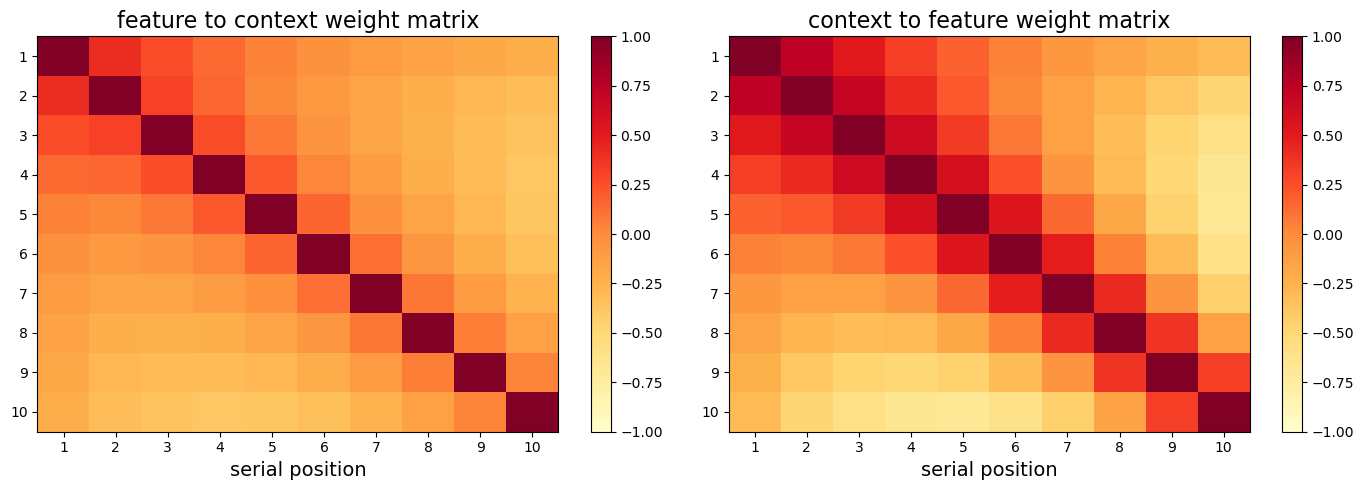

In [69]:
corr_fc = np.corrcoef(net_w_fc_inorder.T)
corr_cf = np.corrcoef(net_w_cf_inorder)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Feature to context correlation matrix
im1 = axes[0].imshow(corr_fc, cmap='YlOrRd', aspect='auto', vmin=-1, vmax=1)
axes[0].set_title('feature to context weight matrix', fontsize=16)
axes[0].set_xlabel('serial position', fontsize=14)
axes[0].set_ylabel('', fontsize=14)
axes[0].set_xticks(np.arange(len(pres_indices)))
axes[0].set_xticklabels(np.arange(1, len(pres_indices) + 1))
axes[0].set_yticks(np.arange(len(pres_indices)))
axes[0].set_yticklabels(np.arange(1, len(pres_indices) + 1))
plt.colorbar(im1, ax=axes[0])

# Context to feature correlation matrix
im2 = axes[1].imshow(corr_cf, cmap='YlOrRd', aspect='auto', vmin=-1, vmax=1)
axes[1].set_title('context to feature weight matrix', fontsize=16)
axes[1].set_xlabel('serial position', fontsize=14)
axes[1].set_ylabel('', fontsize=14)
axes[1].set_xticks(np.arange(len(pres_indices)))
axes[1].set_xticklabels(np.arange(1, len(pres_indices) + 1))
axes[1].set_yticks(np.arange(len(pres_indices)))
axes[1].set_yticklabels(np.arange(1, len(pres_indices) + 1))
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

### Rationale
1. Overall pattern:
   - **Diagonal (perfect correlation)**: Each item correlates perfectly with itself
   - **Near-diagonal bands**: Show temporal neighborhood structure
   - **Off-diagonal patterns**: Reveal long-range associations

2. **Width of diagonal**: temporal resolution of context
   - Narrow band = sharp temporal discrimination
   - Wide band = gradual context change

2. **Asymmetries**: forward/backward association differences

3. **Clustering**: Groups of items with similar correlation profiles

### Interpretation
- Wider diagonal towards the left: early items share more similar contexts because context hasn’t diverged much yet.

- `corr_fc` diagonal thinner than `corr_cf`: because $M^{FC}$ results from weaker learning (`gamma_fc`< 1), while $M^{CF}$ is written strongly (`lrate_cf_enc` = 1).